**Importing dependencies**

In [0]:
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")

Syncing Google drive files to our Google colab notebook

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing datasets using pandas

In [0]:
features=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/features.csv')

In [0]:
stores=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/stores.csv')

In [0]:
train=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/train.csv')

In [0]:
merged_1=train.merge(stores, on=['Store'], how='left')

In [0]:
train=merged_1.merge(features, on=['Store','Date','IsHoliday'], how='left')

Start date of train is 2010-02-05
End date of train is 2012-10-26

Text(0.5,1,'Sales of different departments of Store 1')

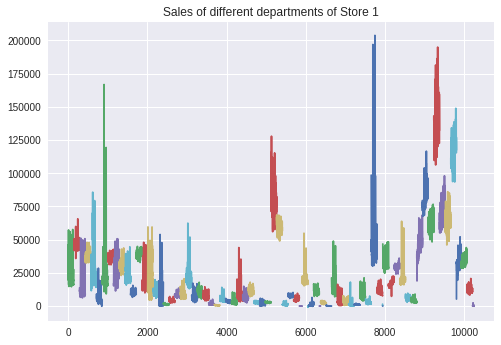

In [8]:
for i in range(100):
  temp=train.iloc[np.where(np.array(train['Store']==1) & np.array(train['Dept']==i))]
  plt.plot(temp['Weekly_Sales'])
plt.title('Sales of different departments of Store 1')

In [0]:
train_dates=np.unique(train['Date'])

**Importing Test data**

In [0]:
test=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/test.csv')

In [0]:
merged_1=test.merge(stores, on=['Store'], how='left')
test=merged_1.merge(features, on=['Store','Date','IsHoliday'], how='left')

In [0]:
train['sales']=train['Weekly_Sales']
train=train.drop('Weekly_Sales',axis=1)

Testing FB Prophet on Store 4 and Department 14

In [0]:
train1=train.iloc[np.where(np.array(train['Store']==4) & np.array(train['Dept']==14))]

In [0]:
date=train1['Date']

In [0]:
train1=train1[['sales','Date']]

In [0]:
train1.shape
train1['ds']=train1['Date']
train1['y']=train1['sales']
train1=train1.drop(['Date','sales'],axis=1)

In [17]:
train1.head(2)

,ds,y
31377,2010-02-05,28027.75
31378,2010-02-12,29498.57


Spliting dataset as 80% sales in training data and 20% for evaluation

In [0]:
train_x=train1[:int(train1.shape[0]*0.8)]
test_x=train1[int(train1.shape[0]*0.8):]

In [0]:
true=test_x['y']
test_x=test_x.drop('y',axis=1)

**FB Prophet**

RMSE: 2265.1355510155154


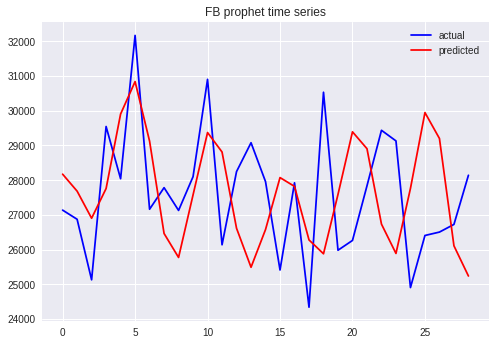

In [20]:
m = Prophet(weekly_seasonality=True,daily_seasonality=True)
m.fit(train1)
predicted=m.predict(test_x)
indices=np.arange(predicted.shape[0])
plt.plot(indices,true,color='b')
plt.plot(indices,predicted['yhat'],color='r')
plt.gca().legend(('actual','predicted'))
plt.title('FB prophet time series')
print('RMSE:',np.sqrt(mse(true,predicted['yhat'])))

**Moving Average**

In [0]:
def forecast_MA(train,test,window=100):
  prediction=np.zeros(test.shape[0])
  prev=train['y'][-window:]
  for i in range(test.shape[0]):
    prediction[i]=np.mean(prev)
    prev=shift(prev,-1,cval=prediction[i])
  
  return prediction

RMSE: 3352.3500669236255


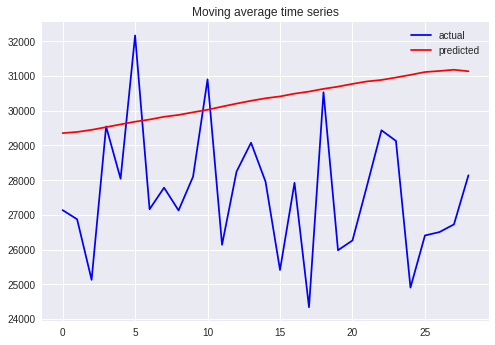

In [22]:
predicted = forecast_MA(train_x,test_x)
indices=np.arange(test_x.shape[0])
plt.plot(indices,true,color='b')
plt.plot(indices,predicted,color='r')
plt.gca().legend(('actual','predicted'))
plt.title('Moving average time series')
print('RMSE:',np.sqrt(mse(true,predicted)))

**Extending FB Prophet to forecast sales of each department of every store**

Test start date 2012-11-02 End date 2013-07-26

In [23]:
test_dates=np.unique(test['Date'])
test_dates=pd.DataFrame({'ds':test_dates})
test_dates.head()

,ds
0,2012-11-02
1,2012-11-09
2,2012-11-16
3,2012-11-23
4,2012-11-30


In [0]:
stores=45
depts=99
test_data_pred=np.zeros((39,stores+1,depts+1))

Using a nested loop to create separate model for each department of each store

In [25]:
'''
for i in range(1,stores+1):
  print('Store',i)
  for j in range(99,depts+1):
    m = Prophet(weekly_seasonality=True,daily_seasonality=True)
    temp=train.iloc[np.where(np.array(train['Store']==i) & np.array(train['Dept']==j))]
    temp=temp[['sales','date']]
    temp['ds']=temp['date']
    temp['y']=temp['sales']
    temp=temp.drop(['date','sales'],axis=1)
    if (temp.shape[0]<2):              
      out=prev
    else:
      m.fit(temp)
      predicted=m.predict(test_dates)
      out=predicted['yhat']
      prev=out
    print(1)
    test_data_pred[:,i,j]=out
'''

"\nfor i in range(1,stores+1):\n  print('Store',i)\n  for j in range(99,depts+1):\n    m = Prophet(weekly_seasonality=True,daily_seasonality=True)\n    temp=train.iloc[np.where(np.array(train['Store']==i) & np.array(train['Dept']==j))]\n    temp=temp[['sales','date']]\n    temp['ds']=temp['date']\n    temp['y']=temp['sales']\n    temp=temp.drop(['date','sales'],axis=1)\n    if (temp.shape[0]<2):              \n      out=prev\n    else:\n      m.fit(temp)\n      predicted=m.predict(test_dates)\n      out=predicted['yhat']\n      prev=out\n    print(1)\n    test_data_pred[:,i,j]=out\n"

In [0]:
#np.save('gdrive/My Drive/DS Project/Nabeel/fb_prophet_prediction.npy',test_data_pred)

Loading saved predictions

In [0]:
test_data_pred=np.load('gdrive/My Drive/DS Project/Nabeel/fb_prophet_prediction.npy')

In [0]:
t=test[['Date','Store','Dept']]

Getting a list of sales for kaggle submission

In [0]:
prediction=[]
for i in range(test.shape[0]):
  index=np.where(test_dates==t['Date'][i])[0][0]
  store_val=t['Store'][i]
  dept_val=t['Dept'][i]
  prediction.append(test_data_pred[index,store_val,dept_val])

Plotting RMSE of different models we employed

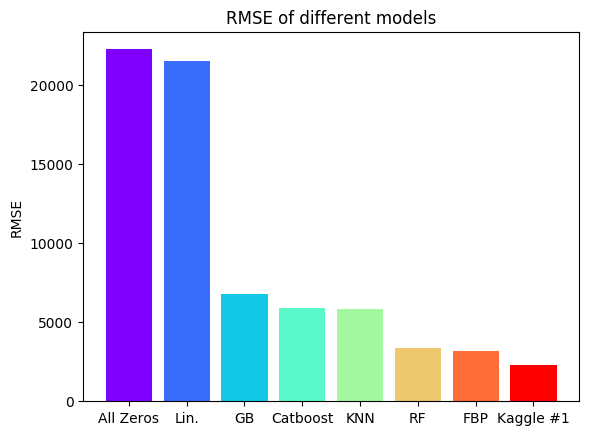

In [30]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, 8))

objects = ('All Zeros', 'Lin.', 'GB','Catboost', 'KNN', 'RF', 'FBP' , 'Kaggle #1')
y_pos = np.arange(len(objects))
performance = [22265,21509,6817,5917,5850,3360, 3204, 2301]
 
plt.bar(y_pos, performance, align='center', alpha=1, color = colors)
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
plt.title('RMSE of different models')
 
plt.show()

In [0]:
submission=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/sampleSubmission.csv')

In [0]:
submission['Weekly_Sales']=prediction

In [0]:
submission.to_csv('gdrive/My Drive/DS Project/Nabeel/fb_prophet_prediction.csv',index=False)